In [87]:
print("hellowworld")

hellowworld


### Build A BasicChat with LangGraph(Graph API)

In [88]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

In [89]:
class State(TypedDict):
    #---->  
    messages:Annotated[list,add_messages] #---> add_messages= reducer. Append the messages instead of rewriting/overwriting them



In [90]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [91]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model
#from langchain_openai ###---> Can use that aswell

llm = ChatGroq(model="llama3-8b-8192")

In [92]:
llm = init_chat_model("groq:llama3-8b-8192")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002249D5EAEA0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002249D5EB6F0>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [93]:
#Node Functionality
def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]} ###---> Statemessages is basically the input. It will also append in the class state

In [94]:
graph_builder = StateGraph(State)
graph_builder.add_node("ChatBot",chatbot)
graph_builder.add_edge(START,"ChatBot")
graph_builder.add_edge("ChatBot",END)

## Compile The Graph
graph=graph_builder.compile()


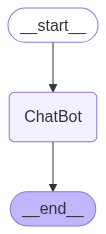

In [95]:
###---> Visualizing The Graph
from IPython.display import Image,display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [96]:
response =  graph.invoke({"messages":"Hi"})

In [97]:
response["messages"][-1].content

"Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?"

In [98]:
for event in graph.stream({"messages":"Hi How are you?"}):
    print(event)


{'ChatBot': {'messages': [AIMessage(content="I'm just a language model, so I don't have feelings like humans do, but I'm functioning properly and ready to help with any questions or tasks you have! It's great to chat with you. How can I assist you today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 15, 'total_tokens': 65, 'completion_time': 0.078407014, 'prompt_time': 0.004407925, 'queue_time': 0.06431244, 'total_time': 0.082814939}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8af39bf2ae', 'finish_reason': 'stop', 'logprobs': None}, id='run--d04a204b-4e66-4688-b73f-2864ffc39445-0', usage_metadata={'input_tokens': 15, 'output_tokens': 50, 'total_tokens': 65})]}}


In [99]:
for event in graph.stream({"messages":"Hi How are you?"}):
    for value in event.values():
        print(value["messages"][-1].content)


I'm just a language model, I don't have emotions or feelings like humans do, but I'm functioning properly and ready to help with any questions or tasks you have! How can I assist you today?


In [100]:
from langchain_tavily import TavilySearch
tool = TavilySearch(max_results=2)

In [101]:
tool.invoke("What is Langraph")

{'query': 'What is Langraph',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'What is LangGraph? - GeeksforGeeks',
   'url': 'https://www.geeksforgeeks.org/machine-learning/what-is-langgraph/',
   'content': 'LangGraph is a Python library that helps you build applications like chatbots or AI agents by organizing their logic step-by-step using state machine model. This step configures your Gemini API key and then we create a simple function ask_gemini that takes user input, sends it to the Gemini model and returns the AI-generated response. Creates a state structure with three fields: question, classification and response which flows through the LangGraph. import matplotlib.pyplot as plt from langgraph.graph import StateGraph\u200bbuilder = StateGraph(GraphState)builder.add_node("classify", classify)builder.add_node("respond", respond)builder.set_entry_point("classify")builder.add_edge("classify", "respond")builder.set_finish_point("respond")app = b

In [102]:
## Custom function
def multiply(a:int,b:int)->int:
    """Multiply a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """
    return a*b

In [103]:
tools=[tool,multiply]
llm_with_tool=llm.bind_tools(tools)
llm_with_tool



RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002249D5EAEA0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002249D5EB6F0>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list 

In [104]:
## StateGraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode

In [105]:
from langgraph.prebuilt import tools_condition
#Node Definitoin
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

graph_builder = StateGraph(State)
graph_builder.add_node("LLMTOOLS",tool_calling_llm)
graph_builder.add_node("tools",ToolNode(tools))
graph_builder.add_edge(START,"LLMTOOLS")

graph_builder.add_conditional_edges(
    "LLMTOOLS",
    tools_condition
)
graph_builder.add_edge("tools",END)

## Compile The Graph
graph=graph_builder.compile()

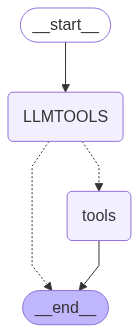

In [106]:
###---> Visualizing The Graph
from IPython.display import Image,display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [107]:
response=graph.invoke({"messages":"What is the recent AI NEWS"})

In [108]:
response["messages"][-1].content

'{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.sciencedaily.com/releases/2025/06/250622030429.htm", "title": "Half of today’s jobs could vanish—Here’s how smart countries are future-proofing workers - ScienceDaily", "score": 0.72768575, "published_date": "Sun, 22 Jun 2025 13:58:28 GMT", "content": "Date:June 22, 2025 Source:University of Georgia Summary:AI is revolutionizing the job landscape, prompting nations worldwide to prepare their workforces for dramatic changes. A University of Georgia study evaluated 50 countries’ national AI strategies and found significant differences in how governments prioritize education and workforce training. While many jobs could disappear in the coming decades, new careers requiring advanced AI skills are emerging. Countries like Germany and Spain are [...] Nov. 20, 2023 — Generative AI (e.g., ChatGPT) has propelled AI into the mainstream, raising concerns about job displacement

In [109]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the recent AI NEWS
================================== Ai Message ==================================
Tool Calls:
  tavily_search (s70a272y8)
 Call ID: s70a272y8
  Args:
    query: recent AI news
    search_depth: advanced
    time_range: day
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.sciencedaily.com/releases/2025/06/250622030429.htm", "title": "Half of today’s jobs could vanish—Here’s how smart countries are future-proofing workers - ScienceDaily", "score": 0.72768575, "published_date": "Sun, 22 Jun 2025 13:58:28 GMT", "content": "Date:June 22, 2025 Source:University of Georgia Summary:AI is revolutionizing the job landscape, prompting nations worldwide to prepare their workforces for dramatic changes. A U

In [110]:
response=graph.invoke({"messages":"What is 2 multiplyed by 3"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is 2 multiplyed by 3
================================== Ai Message ==================================
Tool Calls:
  multiply (736t3m9hy)
 Call ID: 736t3m9hy
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6


In [111]:
response=graph.invoke({"messages":"Give me recent ai NEWS and then  multiplyed 5 by  10"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Give me recent ai NEWS and then  multiplyed 5 by  10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (2fjx1by3h)
 Call ID: 2fjx1by3h
  Args:
    query: recent ai news
    search_depth: advanced
    time_range: day
    topic: news
  multiply (3c3b89n1j)
 Call ID: 3c3b89n1j
  Args:
    a: 5
    b: 10
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.sciencedaily.com/releases/2025/06/250622030429.htm", "title": "Half of today’s jobs could vanish—Here’s how smart countries are future-proofing workers - ScienceDaily", "score": 0.73891455, "published_date": "Sun, 22 Jun 2025 13:58:28 GMT", "content": "Date:June 22, 2025 Source:University of Georgia Summary:AI is revolutionizing the 

In [149]:
from langgraph.prebuilt import tools_condition
#Node Definitoin
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

builder = StateGraph(State)
builder.add_node("tool_calling_llms",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))
builder.add_edge(START,"tool_calling_llms")

builder.add_conditional_edges(
    "tool_calling_llms",
    tools_condition
)
builder.add_edge("tools","tool_calling_llms")
graph=builder.compile()




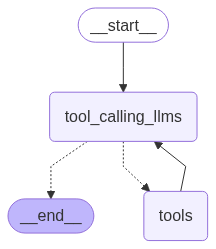

In [150]:
## Compile The Graph

###---> Visualizing The Graph
from IPython.display import Image,display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [151]:
response=graph.invoke({"messages":"Give me the recent ai news also What is 2 multiplyed by 3"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news also What is 2 multiplyed by 3
================================== Ai Message ==================================
Tool Calls:
  tavily_search (1zztgn81z)
 Call ID: 1zztgn81z
  Args:
    query: recent ai news
    time_range: day
    topic: news
  multiply (29yhq5x3s)
 Call ID: 29yhq5x3s
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://gizmodo.com/the-14-billion-ai-google-killer-2000618755", "title": "The $14 Billion AI Google Killer - Gizmodo", "score": 0.604703, "published_date": "Sun, 22 Jun 2025 15:25:16 GMT", "content": "*   Image 6: Ai ModeTech News Gadgets Google’s New AI Mode for Search Cranks Gemini to Max Volume ----------------------------------------------------------- If you wan

### Adding Mmeory Graph in Agent Graph

In [152]:
response=graph.invoke({"messages":"Hello,what is my name"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hello,what is my name
================================== Ai Message ==================================
Tool Calls:
  multiply (9wp324mvb)
 Call ID: 9wp324mvb
  Args:
    a: 0
    b: 0
================================= Tool Message =================================
Name: multiply

0
================================== Ai Message ==================================

I apologize, but it seems that the tool call did not provide any relevant information. As the conversation is starting, I don't have any information about your name. I can try to ask for more context or clarify the question. Can you please provide more details about what you mean by "what is my name"? Are you referring to your username, a nickname, or something else?


In [116]:
response=graph.invoke({"messages":"My Name is Umar"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

My Name is Umar
================================== Ai Message ==================================

Nice to meet you, Umar!


In [117]:
response=graph.invoke({"messages":"Hello,what is my name"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hello,what is my name
================================== Ai Message ==================================

I'm happy to help! However, I don't have any information about your name. Could you please provide me with more context or details so I can better assist you?


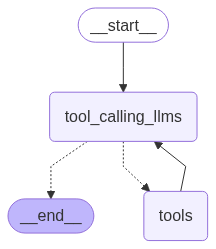

In [163]:
####--------> FORGETTING NAMES/PREVIOUS CHATS

from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import tools_condition

memory = MemorySaver()

#Node Definitoin 
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

builder = StateGraph(State)
builder.add_node("tool_calling_llms",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))
builder.add_edge(START,"tool_calling_llms")

builder.add_conditional_edges(
    "tool_calling_llms",
    tools_condition
)
builder.add_edge("tools","tool_calling_llms")
graph=builder.compile(checkpointer=memory) ###--> Adding Memory of the previous interaction. 
## Compile The Graph

###---> Visualizing The Graph
from IPython.display import Image,display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass




In [164]:
config = {"configurable":{"thread_id":"1"}} # --------> "1" should be unique,numbers 
response = graph.invoke({"messages":"Hi my name is Umar"},config=config)
response



{'messages': [HumanMessage(content='Hi my name is Umar', additional_kwargs={}, response_metadata={}, id='0a2dc1d8-a421-4e21-91ae-082e4d64f99a'),
  AIMessage(content="Nice to meet you, Umar! What's on your mind today? Do you have a question or topic you'd like to discuss?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 2194, 'total_tokens': 2223, 'completion_time': 0.041357053, 'prompt_time': 0.244619418, 'queue_time': 0.06955125300000001, 'total_time': 0.285976471}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8b7c3a83f7', 'finish_reason': 'stop', 'logprobs': None}, id='run--fbdae2ca-e156-43f8-829a-61207e7b06ec-0', usage_metadata={'input_tokens': 2194, 'output_tokens': 29, 'total_tokens': 2223})]}

In [160]:
response['messages'][-1].content

'Nice to meet you, Umar! What brings you here today?'

In [165]:
response = graph.invoke({"messages":"What is my name"},config=config)
response


{'messages': [HumanMessage(content='Hi my name is Umar', additional_kwargs={}, response_metadata={}, id='0a2dc1d8-a421-4e21-91ae-082e4d64f99a'),
  AIMessage(content="Nice to meet you, Umar! What's on your mind today? Do you have a question or topic you'd like to discuss?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 2194, 'total_tokens': 2223, 'completion_time': 0.041357053, 'prompt_time': 0.244619418, 'queue_time': 0.06955125300000001, 'total_time': 0.285976471}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8b7c3a83f7', 'finish_reason': 'stop', 'logprobs': None}, id='run--fbdae2ca-e156-43f8-829a-61207e7b06ec-0', usage_metadata={'input_tokens': 2194, 'output_tokens': 29, 'total_tokens': 2223}),
  HumanMessage(content='What is my name', additional_kwargs={}, response_metadata={}, id='d34dabb8-6610-4fd5-b7b7-1cd694ead832'),
  AIMessage(content='Your name is Umar.', additional_kwargs={}, response_metadata={'token_usage': 

In [166]:
response['messages'][-1].content

'Your name is Umar.'

### Streaming

In [167]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [168]:
#Node Functionality
def superbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]} ###---> Statemessages is basically the input. It will also append in the class state

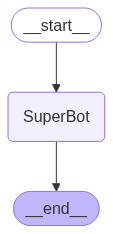

In [171]:

builder = StateGraph(State)
builder.add_node("SuperBot",superbot)

builder.add_edge(START,"SuperBot")
builder.add_edge("SuperBot",END)

## Compile The Graph
graph_builder=builder.compile(checkpointer=memory) ###--> Adding Memory of the previous interaction. 

###---> Visualizing The Graph
from IPython.display import Image,display
try:
    display(Image(graph_builder.get_graph().draw_mermaid_png()))
except Exception:
    pass




In [178]:
#
config = {"configurable":{"thread_id":"1"}}
for chunk in graph_builder.stream({"messages":"Hi,my name is Krish"},config=config,stream_mode="updates"):
    print(chunk) #----------> ONLY OUTPUT

{'SuperBot': {'messages': [AIMessage(content='Nice to meet you, Krish!', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 88, 'total_tokens': 96, 'completion_time': 0.012349057, 'prompt_time': 0.011912476, 'queue_time': 0.06865727699999999, 'total_time': 0.024261533}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8b7c3a83f7', 'finish_reason': 'stop', 'logprobs': None}, id='run--6d932f07-f203-400c-9975-36622a303e56-0', usage_metadata={'input_tokens': 88, 'output_tokens': 8, 'total_tokens': 96})]}}


In [179]:
for chunk in graph_builder.stream({"messages":"Hi,my name is Krish"},config=config,stream_mode="values"):
    print(chunk) #####--------> Everything is displayed

{'messages': [HumanMessage(content='Hi,my name is Krish', additional_kwargs={}, response_metadata={}, id='dffc8be5-f5a0-477a-aa9c-f800a9dcd464'), AIMessage(content="Nice to meet you, Krish! I'm your AI chat partner. It's great to have you here. What brings you to this conversation today? Do you have something specific on your mind that you'd like to talk about, or are you just looking for some casual chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 57, 'prompt_tokens': 16, 'total_tokens': 73, 'completion_time': 0.108799629, 'prompt_time': 0.00885704, 'queue_time': 4.681051368, 'total_time': 0.117656669}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8af39bf2ae', 'finish_reason': 'stop', 'logprobs': None}, id='run--d6d737f6-0eeb-449c-9fe4-b039073f62d9-0', usage_metadata={'input_tokens': 16, 'output_tokens': 57, 'total_tokens': 73}), HumanMessage(content='Hi,my name is Krish', additional_kwargs={}, response_metadata={}, id='aaf093d9-8c16-4

In [186]:
#
config = {"configurable":{"thread_id":"5"}}
for chunk in graph_builder.stream({"messages":"Hi,my name is Krish"},config=config,stream_mode="updates"):
    print(chunk) #----------> ONLY OUTPUT


{'SuperBot': {'messages': [AIMessage(content="Nice to meet you, Krish! It's great to have you here. Is there something you'd like to talk about or ask? I'm all ears!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 16, 'total_tokens': 49, 'completion_time': 0.046491831, 'prompt_time': 0.003916723, 'queue_time': 0.068637618, 'total_time': 0.050408554}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8b7c3a83f7', 'finish_reason': 'stop', 'logprobs': None}, id='run--83018baa-595e-4804-94d4-7be0e391e0bd-0', usage_metadata={'input_tokens': 16, 'output_tokens': 33, 'total_tokens': 49})]}}


In [187]:
for chunk in graph_builder.stream({"messages":"I also like football"},config=config,stream_mode="values"):
    print(chunk) #----------> ONLY OUTPUT


{'messages': [HumanMessage(content='Hi,my name is Krish', additional_kwargs={}, response_metadata={}, id='0da5b8f6-4a56-4c4b-a5ae-f1182590d151'), AIMessage(content="Nice to meet you, Krish! It's great to have you here. Is there something you'd like to talk about or ask? I'm all ears!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 16, 'total_tokens': 49, 'completion_time': 0.046491831, 'prompt_time': 0.003916723, 'queue_time': 0.068637618, 'total_time': 0.050408554}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8b7c3a83f7', 'finish_reason': 'stop', 'logprobs': None}, id='run--83018baa-595e-4804-94d4-7be0e391e0bd-0', usage_metadata={'input_tokens': 16, 'output_tokens': 33, 'total_tokens': 49}), HumanMessage(content='I also like football', additional_kwargs={}, response_metadata={}, id='6155d873-4a6e-4071-97a1-1c9d655f4519')]}
{'messages': [HumanMessage(content='Hi,my name is Krish', additional_kwargs={}, response_metadata

In [190]:
#
config = {"configurable":{"thread_id":"8"}}
async for chunk in graph_builder.astream_events({"messages":"Hi,my name is Krish"},config=config,version="v2"):
    print(chunk) #----------> ONLY OUTPUT


{'event': 'on_chain_start', 'data': {'input': {'messages': 'Hi,my name is Krish'}}, 'name': 'LangGraph', 'tags': [], 'run_id': '5200dd8e-0cdd-452f-92d2-2a4839cb28a6', 'metadata': {'thread_id': '8'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi,my name is Krish', additional_kwargs={}, response_metadata={}, id='572d9ad5-fe05-4f15-998b-7ae4a44e4b62')]}}, 'name': 'SuperBot', 'tags': ['graph:step:1'], 'run_id': 'a5faf486-137b-4fb4-a282-239c145e3d77', 'metadata': {'thread_id': '8', 'langgraph_step': 1, 'langgraph_node': 'SuperBot', 'langgraph_triggers': ('branch:to:SuperBot',), 'langgraph_path': ('__pregel_pull', 'SuperBot'), 'langgraph_checkpoint_ns': 'SuperBot:40e4e832-d2f7-23f6-0eb5-9d787b97cdda'}, 'parent_ids': ['5200dd8e-0cdd-452f-92d2-2a4839cb28a6']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='Hi,my name is Krish', additional_kwargs={}, response_metadata={}, id='572d9ad5-fe05-4f15-998b